In [1]:
import cv2
import numpy as np
import pywt
from skimage import io, feature, measure, metrics
from skimage.filters import threshold_mean, threshold_otsu, threshold_local
from skimage.feature import graycomatrix, graycoprops
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
import threading
from sklearn import preprocessing
from scipy.stats import hmean, gmean, norm
from scipy.ndimage import gaussian_filter, binary_fill_holes, generic_filter, minimum_filter, median_filter, uniform_filter, grey_erosion, grey_dilation, maximum_filter
from distance_regularized_level_set_evolution.find_lsf import find_lsf
from math import sqrt

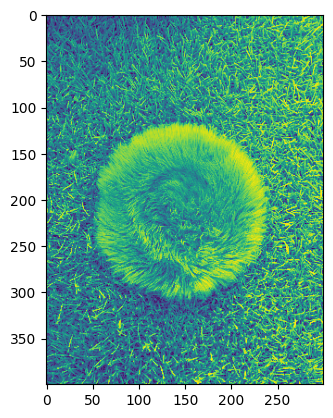

In [2]:
image = cv2.imread("samples/IMG_0426.jpg")
image = cv2.resize(image, (300,400)) 
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.uint8)

n = 27  # size of the sub-image blocks (better if even)
offset = (n - 1) // 2

image_size = gray_image.shape
plt.imshow(gray_image)
plt.show()

## DRLSE

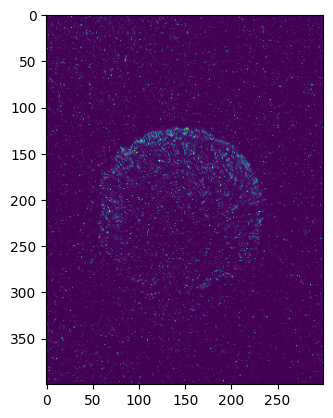

In [3]:
gray_smooth = gaussian_filter(gray_image, 0.8)
[Iy, Ix] = np.gradient(gray_smooth)
f = np.square(Ix) + np.square(Iy)
g = 1 / (1 + f)  # edge indicator function.
plt.imshow(g)
plt.show()

In [4]:
c0 = 2
initial_lsf = c0 * np.ones(g.shape)
initial_lsf[5:-5, 5:-5] = -c0
# initial_lsf[50:350, 50:250] = -c0
# initial_lsf[25:400, 25:400] = -c0
# initial_lsf[70:750, 100:400] = -c0 # lizard

phi = find_lsf(
    g=g, 
    initial_lsf=initial_lsf,
    timestep=1,
    iter_inner=30,
    iter_outer=30,
    lmda=5,
    alfa=2,
    epsilon=1.5)

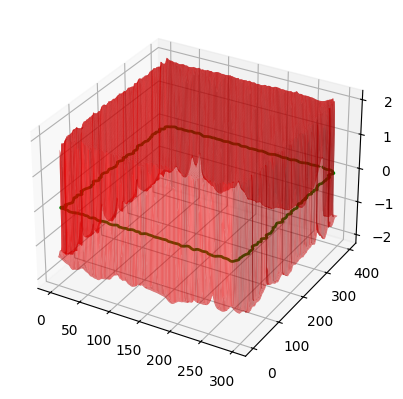

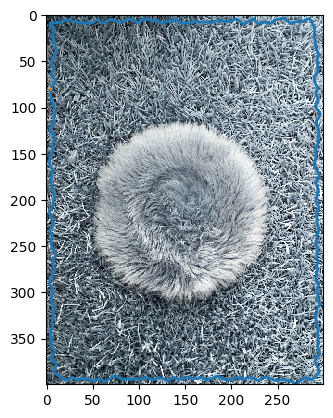

In [5]:
plt.ion()
fig1 = plt.figure(1)
fig2 = plt.figure(2)


fig1.clf()
ax1 = fig1.add_subplot(111, projection='3d')
y, x = phi.shape
x = np.arange(0, x, 1)
y = np.arange(0, y, 1)
X, Y = np.meshgrid(x, y)
ax1.plot_surface(X, Y, -phi, rstride=2, cstride=2, color='r', linewidth=0, alpha=0.6, antialiased=True)
ax1.contour(X, Y, phi, 0, colors='g', linewidths=2)

fig2.clf()
contours = measure.find_contours(phi, 0)
ax2 = fig2.add_subplot(111)
ax2.imshow(image, interpolation='nearest', cmap=plt.get_cmap('gray'))
for contour in contours:
    ax2.plot(contour[:, 1], contour[:, 0], linewidth=2)

## Texture features

### Features

In [6]:
def normalize(image):
    """Normalizes the image intensity values to the range [0, 1]."""
    image_min = np.min(image)
    image_max = np.max(image)
    normalized_image = (image - image_min) / (image_max - image_min)
    return normalized_image

def log_normalize(image):
    """Logarithmically normalizes the image intensity values to the range [0, 1]."""
    image = np.real(np.log(image + 1))
    return normalize(image)

def energy(comat):
    """Calculates the energy feature from the co-occurrence matrix."""
    term = np.power(comat.flatten(), 2)

    return np.sum(term)

def contrast(comat, r, c):
    """Calculates the contrast feature from the co-occurrence matrix."""
    term1 = np.power(r - c, 2)
    term2 = comat.flatten()

    return np.sum(term1 * term2)


def cluster_shade(comat, r, c, Mx, My):
    """Calculates the cluster shade feature from the co-occurrence matrix."""
    term1 = np.power((r - Mx + c - My), 3)
    term2 = comat.flatten()

    return np.sum(term1 * term2)


def cluster_prominence(comat, r, c, Mx, My):
    """Calculates the cluster prominence feature from the co-occurrence matrix."""
    term1 = np.power((r - Mx + c - My), 4)
    term2 = comat.flatten()

    return np.sum(term1 * term2)

In [7]:
def wavelet_coefficient_features(block):
    block = block - np.mean(block, dtype=np.uint8) # idea from Mr Meert Wannes, maybe do something with negative values

    A1, (H1, V1, D1) = pywt.dwt2(block, 'haar')
    # A2, (H2, V2, D2) = pywt.dwt2(A1, 'haar')


    comatrix_level = 32
    distances = [1]
    setup = [
        {
            "image": (block/(256/comatrix_level)).astype(np.uint8),
            "angles": [0, np.pi/4, np.pi/2, 3*np.pi/4]
        },
        {
            "image": ((H1+256)/(256*2/comatrix_level)).astype(np.uint8),
            "angles": [0]
        },
        {
            "image": ((V1+256)/(256*2/comatrix_level)).astype(np.uint8),
            "angles": [np.pi/2]
        },
        {
            "image": ((D1+256)/(256*2/comatrix_level)).astype(np.uint8),
            "angles": [np.pi/4, 3*np.pi/4]
        },
        # {
        #     "image": ((H2 + abs(H2.flatten().min()))/((H2 + abs(H2.flatten().min())).flatten().max()/comatrix_level + 0.001)).astype(np.uint8),
        #     "angles": [0]
        # },
        # {
        #     "image": ((V2 + abs(V2.flatten().min()))/((V2 + abs(V2.flatten().min())).flatten().max()/comatrix_level + 0.001)).astype(np.uint8),
        #     "angles": [np.pi/2]
        # },
        # {
        #     "image": ((D2 + abs(D2.flatten().min()))/((D2 + abs(D2.flatten().min())).flatten().max()/comatrix_level + 0.001)).astype(np.uint8),
        #     "angles": [np.pi/4, 3*np.pi/4]
        # }
    ]

    comatrices = np.array([], dtype=np.int64).reshape(comatrix_level,comatrix_level,0)
    for x in setup:
        subimage = x["image"]
        c = graycomatrix(subimage, distances, x["angles"], levels=comatrix_level, normed=True)
        c = c.reshape((c.shape[0], c.shape[1], c.shape[2]*c.shape[3]))
        comatrices = np.concatenate((comatrices, c), axis=2)

    r, c = np.meshgrid(np.arange(comatrices.shape[0]), np.arange(comatrices.shape[1]))
    r = r.flatten() + 1
    c = c.flatten() + 1

    features = np.zeros((8,7))

    for ci in range(comatrices.shape[2]):
        Mx = np.sum(r * comatrices[:,:,ci].flatten())
        My = np.sum(c * comatrices[:,:,ci].flatten())

        features[ci, 0] = graycoprops(comatrices[:,:,ci].reshape(comatrix_level,comatrix_level,1,1), 'contrast')[0,0]
        features[ci, 1] = cluster_shade(comatrices[:,:,ci], r, c, Mx, My) + cluster_prominence(comatrices[:,:,ci], r, c, Mx, My)
        features[ci, 2] = graycoprops(comatrices[:,:,ci].reshape(comatrix_level,comatrix_level,1,1), 'energy')[0,0]
        features[ci, 3] = graycoprops(comatrices[:,:,ci].reshape(comatrix_level,comatrix_level,1,1), 'dissimilarity')[0,0]
        features[ci, 4] = graycoprops(comatrices[:,:,ci].reshape(comatrix_level,comatrix_level,1,1), 'homogeneity')[0,0]
        features[ci, 5] = graycoprops(comatrices[:,:,ci].reshape(comatrix_level,comatrix_level,1,1), 'ASM')[0,0]
        features[ci, 6] = graycoprops(comatrices[:,:,ci].reshape(comatrix_level,comatrix_level,1,1), 'correlation')[0,0]
    
    return features

In [8]:
WCFs = np.zeros((image_size[0], image_size[1], 8, 7))

class fnc_class:
    def __init__(self, _array):
        # store the shape:
        self.shape = _array.shape
        self._array = _array
        # initialize the coordinates:
        self.coordinates = [0] * len(self.shape[:2])
        
    def filter(self, buffer):
        block = buffer.reshape(n,n)

        self._array[self.coordinates[0], self.coordinates[1]] = wavelet_coefficient_features(block)

        # calculate the next coordinates:
        axes = range(len(self.shape[:2]))
        for jj in reversed(axes):
            if self.coordinates[jj] < self.shape[jj] - 1:
                self.coordinates[jj] += 1
                break
            else:
                self.coordinates[jj] = 0

        return 0

fnc = fnc_class(WCFs)
generic_filter(gray_image, fnc.filter, n)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [9]:
# filename = 'WCFs_lizard.npy'
# filename = 'WCFs_simple_lizard.npy'
# filename = 'WCFs_different_props.npy'


# with open(filename, 'wb') as f:
#     np.save(f, WCFs)

# with open(filename, 'rb') as f:
#     WCFs = np.load(f)

In [10]:
def plot_features(features):
    for i in range(features.shape[3]):
        for j in range(features.shape[2]):
            plt.subplot(features.shape[3],features.shape[2],(i*features.shape[2])+j+1)
            plt.imshow(features[:,:,j,i])
    plt.show()

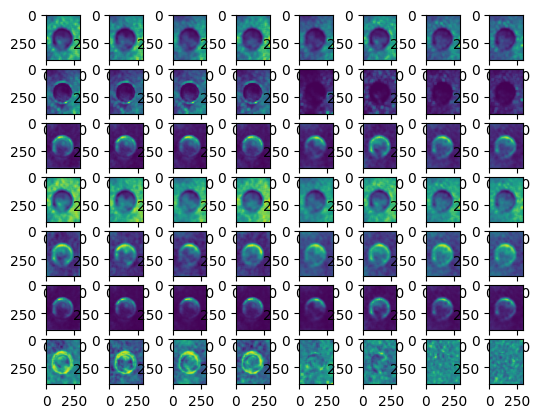

In [11]:
plot_features(WCFs)

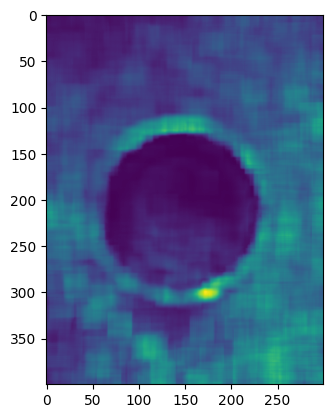

In [12]:
plt.imshow(np.mean(np.mean(WCFs, 3), 2))
plt.show()

In [13]:
normalizedWCFs = np.zeros(WCFs.shape)
for i in range(WCFs.shape[2]):
    normalizedWCFs[:,:, i, 0] = normalize(WCFs[:,:,i, 0])
    normalizedWCFs[:,:, i, 1] = log_normalize(WCFs[:,:,i, 1])
    normalizedWCFs[:,:, i, 2] = normalize(WCFs[:,:,i, 2])
    normalizedWCFs[:,:, i, 3] = normalize(WCFs[:,:,i, 3])
    normalizedWCFs[:,:, i, 4] = normalize(WCFs[:,:,i, 4])
    normalizedWCFs[:,:, i, 5] = normalize(WCFs[:,:,i, 5])
    normalizedWCFs[:,:, i, 6] = normalize(WCFs[:,:,i, 6])

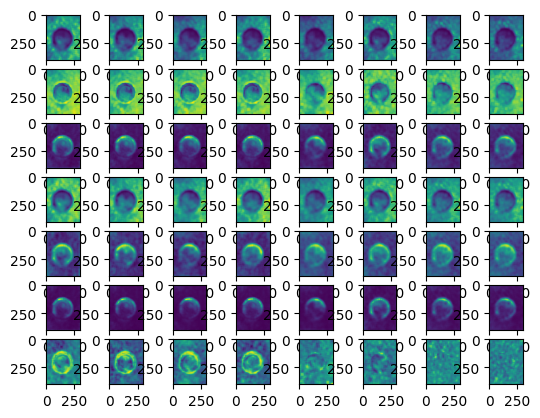

In [14]:
plot_features(normalizedWCFs)
plt.show()

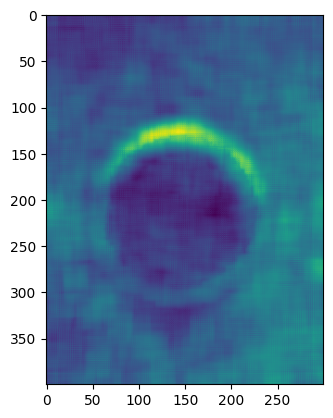

In [15]:
plt.imshow(np.mean(np.mean(normalizedWCFs, 3), 2))
plt.show()

In [16]:
normalizedWCFs = np.zeros(WCFs.shape)
for i in range(WCFs.shape[2]):
    for j in range(WCFs.shape[3]):
        blurred = gaussian_filter(WCFs[:,:,i, j], 0.8)
        erosion = grey_erosion(blurred, 3)
        normalizedWCFs[:,:, i, j] = grey_dilation(erosion, 3)
        
    normalizedWCFs[:,:, i, 0] = normalize(normalizedWCFs[:,:,i, 0])
    normalizedWCFs[:,:, i, 1] = log_normalize(normalizedWCFs[:,:,i, 1])
    normalizedWCFs[:,:, i, 2] = normalize(normalizedWCFs[:,:,i, 2])
    normalizedWCFs[:,:, i, 3] = normalize(normalizedWCFs[:,:,i, 3])
    normalizedWCFs[:,:, i, 4] = normalize(normalizedWCFs[:,:,i, 4])
    normalizedWCFs[:,:, i, 5] = normalize(normalizedWCFs[:,:,i, 5])
    normalizedWCFs[:,:, i, 6] = normalize(normalizedWCFs[:,:,i, 6])

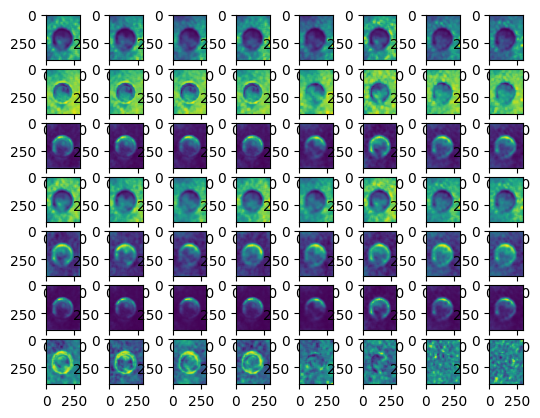

In [17]:
plot_features(normalizedWCFs)

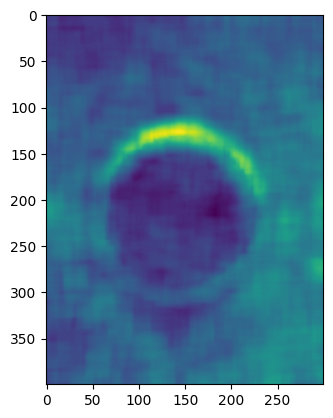

In [18]:
plt.imshow(np.mean(np.mean(normalizedWCFs, 3), 2))
plt.show()

In [19]:
def invert(X):
    return (X - 1) * -1

invertedWCFs = normalizedWCFs.copy()
X = np.zeros((0, image_size[0], image_size[1]))
for i in range(WCFs.shape[2]):
    for j in range(WCFs.shape[3]):
        if metrics.mean_squared_error(np.mean(X, axis=0), np.mean(np.concatenate((X, [invertedWCFs[:,:,i,j]]), axis=0), axis=0)) > metrics.mean_squared_error(np.mean(X, axis=0), np.mean(np.concatenate((X, [invert(invertedWCFs[:,:,i,j])]), axis=0), axis=0)):
            invertedWCFs[:,:, i, j] = invert(invertedWCFs[:,:,i, j])

        X = np.concatenate((X, [invertedWCFs[:,:,i,j]]), axis=0)
    
    # for j in range(WCFs.shape[3]):
    #     x = np.mean(normalizedWCFs[:,:,i,j])
    #     y = np.mean(normalizedWCFs[:,:,0,0][phi<0])
    #     if x > y:
    #         invertedWCFs[:,:,i,j] = (normalizedWCFs[:,:,i,j] - 1) * -1
    #     else:
    #         invertedWCFs[:,:,i,j] = normalizedWCFs[:,:,i,j]

d:\Projects\Masterproef\unsupervised-image-segmentation-texture-based\.venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\Projects\Masterproef\unsupervised-image-segmentation-texture-based\.venv\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


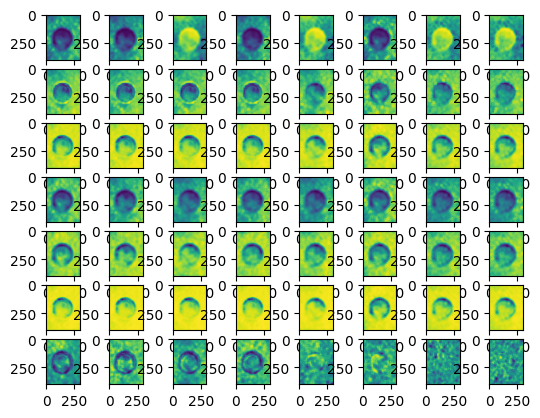

In [20]:
plot_features(invertedWCFs)

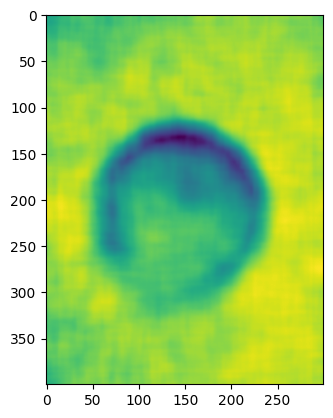

In [21]:
plt.imshow(np.mean(np.mean(invertedWCFs, 3), 2))
plt.show()

In [22]:
smoothedWCFs = np.zeros(WCFs.shape)
for i in range(WCFs.shape[2]):
    for j in range(WCFs.shape[3]):
        smoothedWCFs[:,:, i, j] = median_filter(invertedWCFs[:,:,i,j], n)

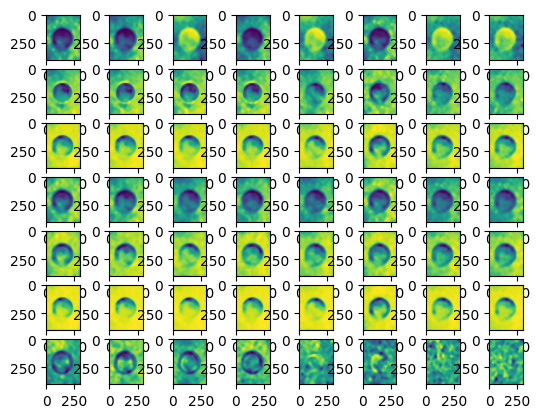

In [23]:
plot_features(smoothedWCFs)

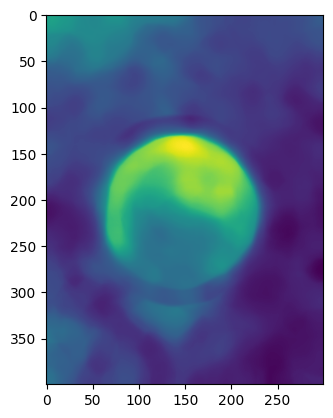

In [24]:
plt.imshow(invert(np.mean(np.mean(smoothedWCFs[:,:,:,1:2], 3), 2)))
plt.show()

In [25]:
combinedWCFs = np.mean(np.mean(smoothedWCFs[:,:,:,1:2], 3), 2)
# combinedWCFs = gmean(gmean(smoothedWCFs, 3), 2)
# combinedWCFs = hmean(hmean(smoothedWCFs + 0.000000001, 3), 2)

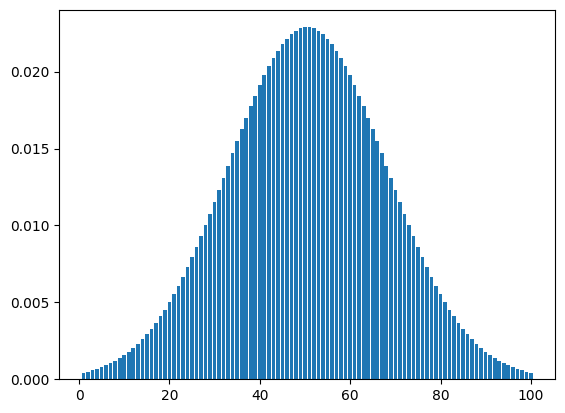

In [26]:
size = 100

def gaussian_weights(size, sigma):
    x = np.linspace(-1, 1, size)
    weights = np.exp(-(x / sigma)**2)
    return weights / np.sum(weights)


weighted_array = gaussian_weights(size, 0.5)

indices = np.arange(1, size + 1)  # x-axis values

plt.bar(indices, weighted_array)
plt.show()

In [27]:
def gaussian_minimum(Y):
    X = np.sort(Y.copy())

    size = len(X)
    half = size//2

    sigma = 0.1
    
    x = np.linspace(-1, 1, size)
    weights = np.exp(-(x / sigma)**2)
    weights = weights / np.sum(weights)

    sum = 0
    for i, x in enumerate(X[:half]):
        sum += weights[i+half] * 2 * x

    return sum

filteredWCFs = generic_filter(invert(combinedWCFs), gaussian_minimum, n)
# filteredWCFs = minimum_filter(combinedWCFs, n)

# doesn't work because otherwise region info will get unaccurate
# filteredWCFs = np.zeros(WCFs.shape)
# for i in range(WCFs.shape[2]):
#     for j in range(WCFs.shape[3]):
#         filteredWCFs[:,:, i, j] = minimum_filter(invertedWCFs[:,:,i,j], n)

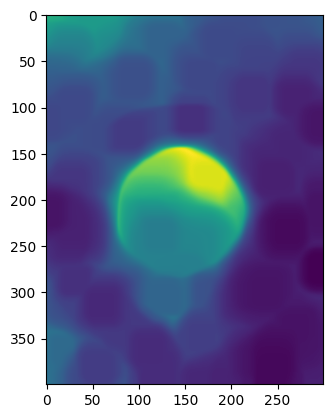

In [28]:
plt.imshow(filteredWCFs)
plt.show()

### Segementation band

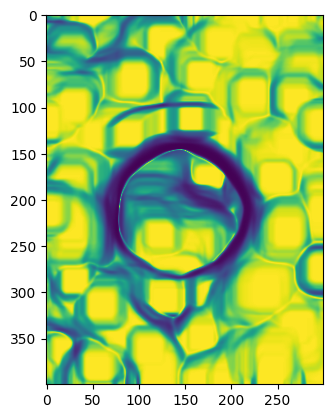

In [39]:
[Iy, Ix] = np.gradient(filteredWCFs * 255)
f = np.square(Ix) + np.square(Iy)
g = 1 / (1 + f)

# gray_smooth = gaussian_filter(gray_image, 0.8)
# [Iy, Ix] = np.gradient(gray_smooth)
# f = np.square(Ix) + np.square(Iy)
# g2 = 1 / (1 + f)  # edge indicator function.
# plt.imshow(g2)
# plt.show()

plt.imshow(g)
plt.show()

In [30]:
phi_modified = find_lsf(
    g=g, 
    initial_lsf=phi,
    timestep=1,
    iter_inner=30,
    iter_outer=90,
    lmda=20,
    alfa=3, # By how much to move the interface (pixel wise) ????
    epsilon=1.5)

In [40]:
phi_modified = find_lsf(
    g=g, 
    initial_lsf=phi,
    timestep=1,
    iter_inner=30,
    iter_outer=60,
    lmda=20,
    alfa=3, # By how much to move the interface (pixel wise) ????
    epsilon=.1)

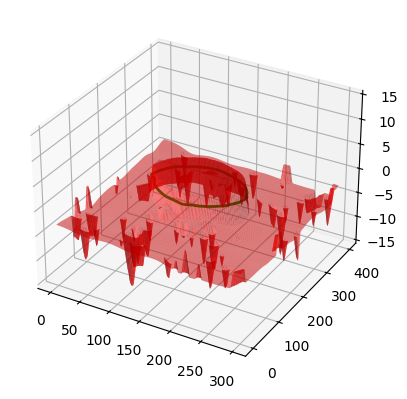

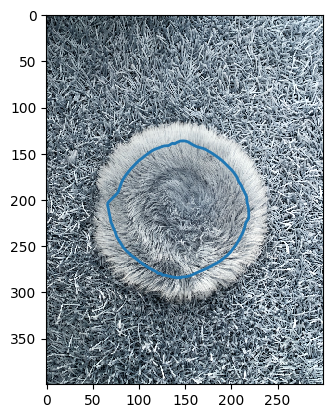

In [41]:
plt.ion()
fig1 = plt.figure(1)
fig2 = plt.figure(2)


fig1.clf()
ax1 = fig1.add_subplot(111, projection='3d')
y, x = phi_modified.shape
x = np.arange(0, x, 1)
y = np.arange(0, y, 1)
X, Y = np.meshgrid(x, y)
ax1.plot_surface(X, Y, -phi_modified, rstride=2, cstride=2, color='r', linewidth=0, alpha=0.6, antialiased=True)
ax1.contour(X, Y, phi_modified, 0, colors='g', linewidths=2)

fig2.clf()
contours = measure.find_contours(phi_modified, 0)
ax2 = fig2.add_subplot(111)
ax2.imshow(image, interpolation='nearest', cmap=plt.get_cmap('gray'))
for contour in contours:
    ax2.plot(contour[:, 1], contour[:, 0], linewidth=2)